tgb - 3/4/2020 - Preparing figures for our March 2020 PRL submission. Draws heavily from notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/022_Figure_Conserving_NN.ipynb]

# Initialization

## Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

## Plot properties

In [2]:
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [36]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=fz)
# mpl.rcParams['lines.linewidth'] = lw
# plt.close('all')

In [45]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Figure 3

Old version at [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/022_Figure_Conserving_NN.ipynb]

## Load data to plot Figure 3a

In [46]:
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
NNarray = ['MLRL0','JNNL','JNNL0.01','JNNC']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
DATASET = ['train','valid','test']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [47]:
# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [48]:
# Load LCnet diagnostics
hf = open(pathPKL+'2020_03_11_across_alpha.pkl','rb')
S = pickle.load(hf)
hf.close()

In [49]:
# Load comparison between UCnet, linear, etc.
hf = open(pathPKL+'2020_03_06_comparison.pkl','rb')
S2 = pickle.load(hf)
hf.close()

In [50]:
MSEplot = {}
PENplot = {}

for j,datas in enumerate(DATASET):
    #print('datas=',datas)
    MSEplot[datas] = {}
    PENplot[datas] = {}
    
    for alpha in alpha_array:
        #print('alpha = ',str(alpha))
        MSEplot[datas][alpha] = np.log10(S['MSEt'][datas][alpha][0])
        PENplot[datas][alpha] = np.log10(S['RESt'][datas][alpha][0])
        
    for NNs in NNarray:
        MSEplot[datas][NNs] = np.log10(S2['MSEt'][datas][NNs][0])
        PENplot[datas][NNs] = np.log10(S2['RESt'][datas][NNs][0])

## Load data to plot Figure 3b

In [60]:
var = 'Enthalpy'
lat_ind = np.arange(0,64)
nt = 100

if var=='Water':
    Bdic = ['TOT','LHF','PREC','WAT']; 
    Rdic = ['TOT','PREC','WAT','CROSS']
elif var=='Enthalpy':
    Bdic = ['TOT','THERMO','RAD','PHAS','SHFLX'];
    Rdic = ['TOT','THERMO','RAD','PHAS','SHFLX','CROSS'];
    
import pickle
M = {}
for i,NNs in enumerate(NNarray):
    print('i=',i,'NNs=',NNs,'           ',end='\r')
    M[NNs] = {}
    for j,datas in enumerate(DATASET):
        print('j=',j,'datas=',datas,'           ')
        filename = '2020_03_09_018_ENTdiagno'+NNs+datas+str(nt)+'.pkl'
        hf = open(filename,'rb')
        M[NNs][datas] = pickle.load(hf)

j= 0 datas= train            


FileNotFoundError: [Errno 2] No such file or directory: '2020_03_09_018_ENTdiagnoMLRL0train100.pkl'

## Make both figures on same plot

In [51]:
datas = 'valid'

0 −1
1 0
2 1
3 2
4 3
5 4


NameError: name 'M' is not defined

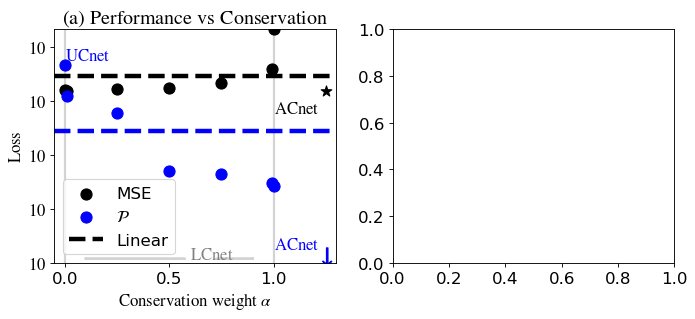

In [57]:
f = plt.figure(num=None, figsize=(10,4), dpi=80, facecolor='w', edgecolor='k')
plt.gcf().subplots_adjust(bottom=0.15) # Make room for xlabels

### Subplot 1 ###

ax = f.add_subplot(1,2,1)
MSEs = {}; PENs = {};

plt.axvline(x=0,color='lightgray',linewidth=lw/2,zorder=0)
plt.axvline(x=1,color='lightgray',linewidth=lw/2,zorder=0)

STR = 'MLRL0'
Hlin1 = plt.axhline(y=MSEplot[datas][STR],c='k',linestyle='--',zorder=1)
Hlin2 = plt.axhline(y=PENplot[datas][STR],c='b',linestyle='--',zorder=1)

for alpha in alpha_array:
    STR = alpha
    MSEs[str(alpha)] = plt.scatter(alpha,MSEplot[datas][STR],c='k',s=siz)
    PENs[str(alpha)] = plt.scatter(alpha,PENplot[datas][STR],c='b',s=siz)

STR = 'JNNC'
MSEs['NNA'] = plt.scatter(XNNA,MSEplot[datas][STR],c='k',s=siz,marker='*')
PENs['NNA'] = plt.scatter(XNNA,YMIN+0.1,c='b',s=3*siz,marker="$\downarrow$")
MSEt = plt.text(XNNA-XTEXT,MSEplot[datas][STR]-YTEXT-0.1,s='$\mathrm{ACnet}$',color='k')
PENt = plt.text(XNNA-XTEXT,YMIN+0.1+YTEXT/2,s='$\mathrm{ACnet}$',color='b')
PENu = plt.text(0,2.75,s='$\mathrm{UCnet}$',color='b')
    
plt.xlim((-0.05,1.3))
plt.ylim((YMIN,3.33))

plt.xlabel(r'$\mathrm{Conservation\ weight\ }\alpha$')
plt.ylabel(r'$\mathrm{Loss}$')
plt.title(r'$\mathrm{\left(a\right)\ }\mathrm{Performance\ vs\ Conservation}$')

plt.legend((MSEs['0'],PENs['0'],Hlin1),\
           ('MSE','$\cal{P}$','Linear'),
          loc='lower left')

# Add LCnet legend
plt.arrow(0.475, -0.925, -0.475, 0, color='lightgray', linewidth=lw/2)
plt.arrow(0.725, -0.925, 0.275, 0, color='lightgray', linewidth=lw/2)
PENu = plt.text(0.5,-0.925,s='$\mathrm{LCnet}$',color='gray')

plt.draw()
# Change y labels to 10^n
labels = [item.get_text() for item in ax.get_yticklabels()]
for ilab,lab in enumerate(labels):
    print(ilab,lab)
    labels[ilab]='$10^{'+lab[1:-1]+'}$'
ax.set_yticklabels(labels)

### Subplot 2 ###

ax = f.add_subplot(1,2,2)
MSEs = {}; PENs = {};


REF = M[NNsREF]['error']['THERMO'][:,:,0].mean(axis=1)

ETHERMOs = {}; ETOTs = {};
for imodel,NNs in enumerate(NNplot):
    ETHERMOs[NNs] = plt.plot(coor.lat,\
                             np.log10(M[NNs]['error'][VAR][:,:,0].mean(axis=1)-REF),\
                             color=cplot[imodel],label=LAB[imodel])
    ETOTs[NNs] = plt.plot(coor.lat,\
                          np.log10(M[NNs]['error']['TOT'][:,:,0].mean(axis=1)),\
                          color=cplot[imodel],linestyle='--',label=LAB[np.size(NNplot)+imodel])

plt.grid()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.xlim((np.min(coor.lat),np.max(coor.lat)))

# Text
N2NETt = plt.text(54,3.65,s='$\mathrm{UCnet2}$',color='g')
NNETt = plt.text(54,2.15,s='$\mathrm{UCnet1}$',color='b')
LCNETt = plt.text(55,1,s='$\mathrm{LCnet}$',color='r')
LCNETt2 = plt.text(54,0.75,s='$\\alpha=1\\% $',color='r')

# plt.ylim((YMIN,3.33))
plt.xlabel(r'$\mathrm{Latitude\ \left(^{\circ}\right)}$')
plt.ylabel(r'$\mathrm{Relative\ Error}$',labelpad=10)
plt.title(r'$\mathrm{\left(b\right)\ }\mathrm{MSE\ relative\ to\ ACnet}$')
plt.legend(loc='center left',fontsize=2*fz/3)

plt.draw()
# Change y labels to 10^n
labels = [item.get_text() for item in ax.get_yticklabels()]
for ilab,lab in enumerate(labels):
    print(ilab,lab)
    labels[ilab]='$10^{'+lab[1:-1]+'}$'
ax.set_yticklabels(labels)

# Save figure
#plt.savefig('Fig3',format='pdf')


# Vertical profiles of squared error

In [4]:
#path_coor = "/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc"
path_coor = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0001-01-01-00000.nc'

In [5]:
coor = xr.open_dataset(path_coor,decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

## Comparison between linear, UCnet, LCnet and ACnet

### From model

In [27]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

In [28]:
NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
NNname = ['$\mathrm{UCnet}$','$\mathrm{LCnet_{0.01}}$','$\mathrm{ACnet}$','$\mathrm{Linear}$']
DATASET = ['train','valid','test']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'

In [29]:
MSEv = {}
MSEt = {}
RESt = {}

for datas in DATASET:
    MSEv[datas] = {}
    MSEt[datas] = {}
    RESt[datas] = {}
    
for NNs in NNarray:
    print('NNs = ',NNs)
    MSEv[datas][NNs] = {}
    MSEt[datas][NNs] = {}
    RESt[datas][NNs] = {}
    
    for datas in DATASET:
        print('dataset=',datas)
        # 1) Load model
        print('Loading model')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
        NN = load_model(path,custom_objects=dict_lay)

        # 2) Define model diagnostics object
        print('Building model diagnostics object')
        md = ModelDiagnostics(NN,config_fn,data_fn)

        # 3) Calculate statistics and save in pickle file
        print('Calculating mean-squared error')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'md_'+datas+'.pkl'
        md.stats = pickle.load(open(path,'rb'))
        MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
        MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))

        # 4) Calculate budget residuals and save in pickle file
        print('Calculating residual')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'res_'+datas+'.pkl'
        md.res = pickle.load(open(path,'rb'))
        tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
        RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

NNs =  JNNL
dataset= train
Loading model


OSError: Unable to open file (unable to open file: name = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/JNNL.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [30]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(e\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(f\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [31]:
f = plt.figure(num=None, figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label=NNname[i])
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==5 or ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==4:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==6:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2 or ifig==4: labels[ilab]=''
        elif ifig==6: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
# Save figure
# plt.savefig('Fig4.pdf',format='pdf')

KeyError: 'JNNL'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fba0fbbbd08> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)

kpathsea: Running mktexfmt latex.fmt
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt: kpsewhich -var-value=TEXMFROOT failed, aborting early.
BEGIN failed--compilation aborted at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)

kpathsea: Running mktexfmt latex.fmt
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt: kpsewhich -var-value=TEXMFROOT failed, aborting early.
BEGIN failed--compilation aborted at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




<Figure size 1200x560 with 1 Axes>

In [7]:
# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [27]:
hf = open(pathPKL+'2020_03_06_comparison.pkl','wb')
S = {"MSEv":MSEv,"MSEt":MSEt,"RESt":RESt,"lev":coor.lev}
pickle.dump(S,hf)
hf.close()

### From reduced data

In [32]:
# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [33]:
hf = open(pathPKL+'2020_03_06_comparison.pkl','rb')
S = pickle.load(hf)
hf.close()
MSEv = S['MSEv']
lev = S['lev']

In [34]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(e\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(f\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [35]:
NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
NNname = ['$\mathrm{UCnet}$','$\mathrm{LCnet_{0.01}}$','$\mathrm{ACnet}$','$\mathrm{Linear}$']
DATASET = ['train','valid','test']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'

In [36]:
f = plt.figure(num=None, figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label=NNname[i])
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==5 or ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==4:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==6:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2 or ifig==4: labels[ilab]=''
        elif ifig==6: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig('Fig_prof_comparison.pdf',format='pdf')

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)

kpathsea: Running mktexfmt latex.fmt
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt: kpsewhich -var-value=TEXMFROOT failed, aborting early.
BEGIN failed--compilation aborted at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)

kpathsea: Running mktexfmt latex.fmt
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt: kpsewhich -var-value=TEXMFROOT failed, aborting early.
BEGIN failed--compilation aborted at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




<Figure size 1200x560 with 2 Axes>

## Sensitivity to Residual Level 

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/020_Sensitivity_Residual_level_Conservation.ipynb]

### From model

In [26]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice': MassConsLayer_choice,\
            'EntConsLayer_choice': EntConsLayer_choice}

NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']; 
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['valid','test']

In [26]:
MSEv = {}
MSEt = {}
RESt = {}

for j,datas in enumerate(DATASET):
    MSEv[datas] = {}
    MSEt[datas] = {}
    RESt[datas] = {}
    #print('j=',j,'and datas=',datas)
    data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_'+datas+'.nc'
    for i,NNs in enumerate(NNarray):
        print('i =',i,' so case #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        #print('Loading model') # 1) Load model
        NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.'+FOR,custom_objects=dict_lay)
        #print('Loading statistics') # 2) Define model diagnostics object
        print(NNs)
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        path_end = 'md'+str(datas)+'.pkl'
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
        MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))
        # 4) Load residuals
        path_end = 'mdres'+str(datas)+'.pkl'
        md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
        RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

i = 0  so case # 1
Cm0_e0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 1  so case # 2
Cm14_e14


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 2  so case # 3
Cm29_e29


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 3  so case # 4
Cm0_e29


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 4  so case # 5
Cm29_e0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 0  so case # 6
Cm0_e0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 1  so case # 7
Cm14_e14


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 2  so case # 8
Cm29_e29


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 3  so case # 9
Cm0_e29


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 4  so case # 10
Cm29_e0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [7]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

In [8]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

ValueError: num must be 1 <= num <= 4, not 5

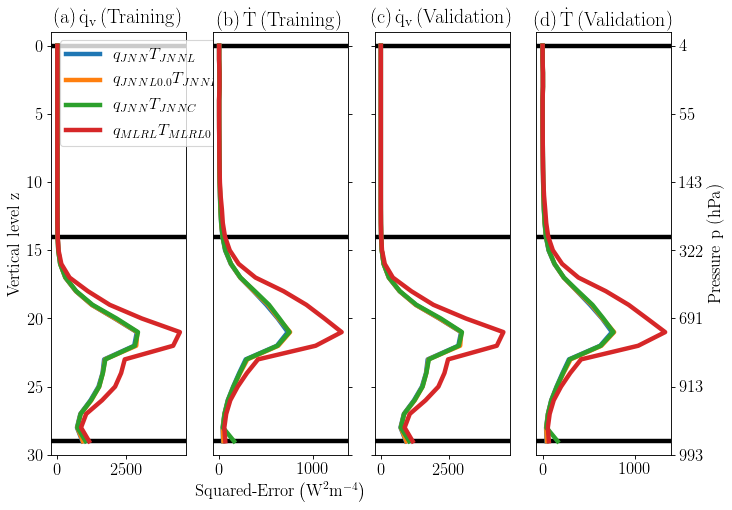

In [25]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)
    
    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        pU = nn.find('_')
        pm = nn.find('m')
        pe = nn.find('e')

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label='$q_{'+nn[pm+1:pU]+'}T_{'+nn[pe+1:]+'}$')
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
# Save figure
# plt.savefig('Fig4.pdf',format='pdf')

In [29]:
datas = 'valid'
for i,nn in enumerate(NNarray):
    print(datas,i,nn,'MSE',MSEt[datas][NNs])
    print(datas,i,nn,'RES',RESt[datas][NNs])
    
datas = 'test'
for i,nn in enumerate(NNarray):
    print(datas,i,nn,'MSE',MSEt[datas][NNs])
    print(datas,i,nn,'RES',RESt[datas][NNs])

valid 0 Cm0_e0 MSE (157.3515652764862, 979.1322196215859)
valid 0 Cm0_e0 RES (7.617920535100867e-10, 1.2654637146166686e-09)
valid 1 Cm14_e14 MSE (157.3515652764862, 979.1322196215859)
valid 1 Cm14_e14 RES (7.617920535100867e-10, 1.2654637146166686e-09)
valid 2 Cm29_e29 MSE (157.3515652764862, 979.1322196215859)
valid 2 Cm29_e29 RES (7.617920535100867e-10, 1.2654637146166686e-09)
valid 3 Cm0_e29 MSE (157.3515652764862, 979.1322196215859)
valid 3 Cm0_e29 RES (7.617920535100867e-10, 1.2654637146166686e-09)
valid 4 Cm29_e0 MSE (157.3515652764862, 979.1322196215859)
valid 4 Cm29_e0 RES (7.617920535100867e-10, 1.2654637146166686e-09)
test 0 Cm0_e0 MSE (155.1995437196781, 970.8405595969147)
test 0 Cm0_e0 RES (7.685692005833281e-10, 1.2997373868778616e-09)
test 1 Cm14_e14 MSE (155.1995437196781, 970.8405595969147)
test 1 Cm14_e14 RES (7.685692005833281e-10, 1.2997373868778616e-09)
test 2 Cm29_e29 MSE (155.1995437196781, 970.8405595969147)
test 2 Cm29_e29 RES (7.685692005833281e-10, 1.29973738

In [30]:
# Save reduced data to make figure
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [31]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','wb')
S = {"MSEv":MSEv,"MSEt":MSEt,"RESt":RESt,"lev":coor.lev}
pickle.dump(S,hf)
hf.close()

### From reduced data

In [10]:
# Save reduced data to make figure
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [11]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEv = S['MSEv']
lev = S['lev']

In [12]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

In [13]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice': MassConsLayer_choice,\
            'EntConsLayer_choice': EntConsLayer_choice}

NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']; 
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['valid','test']

In [14]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

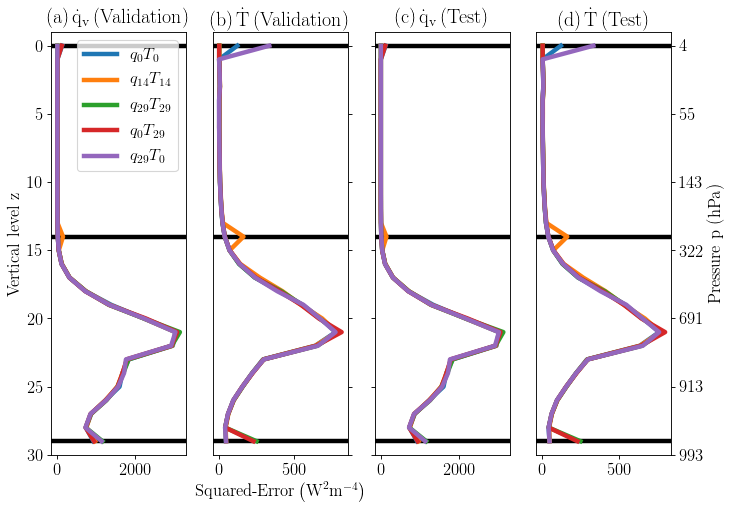

In [15]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)
    
    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        pU = nn.find('_')
        pm = nn.find('m')
        pe = nn.find('e')

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label='$q_{'+nn[pm+1:pU]+'}T_{'+nn[pe+1:]+'}$')
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig('Fig_prof_reslev.pdf',format='pdf')

## Targetting residual bias by using weighted loss

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/036_ACnet_Targetted_Loss.ipynb]

In [19]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [11]:
S = {}

hf = open(pathPKL+'2020_03_04_validgen036.pkl','rb')
S['valid'] = pickle.load(hf)
hf.close()

hf = open(pathPKL+'2020_03_04_testgen036.pkl','rb')
S['test'] = pickle.load(hf)
hf.close()

In [12]:
mult_array = np.array([1,2,5,10,20])

In [17]:
DATASET = ['valid','test']

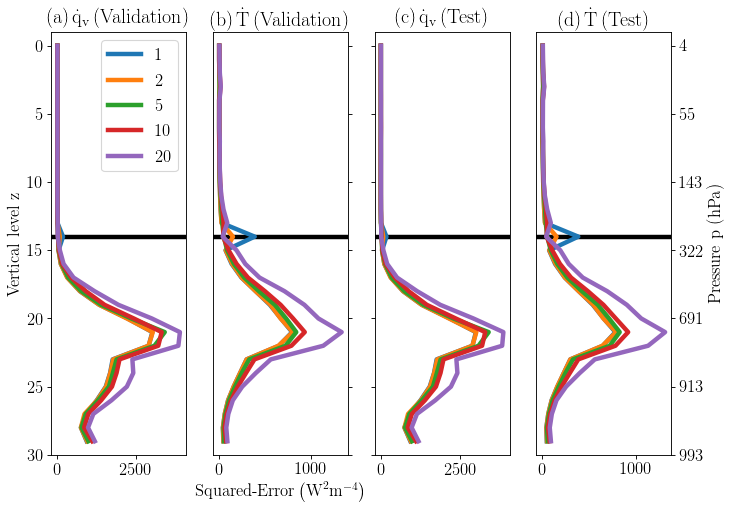

In [22]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):

        ax.plot(np.mean(S[datas]['SE'][multiplier][:,:30],axis=0),
                np.linspace(0,29,num=30),
                label=multiplier)
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):
        ax.plot(np.mean(S[datas]['SE'][multiplier][:,90:120],axis=0),
                np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)

#Save figure
plt.savefig('Fig_prof_wloss.pdf',format='pdf')

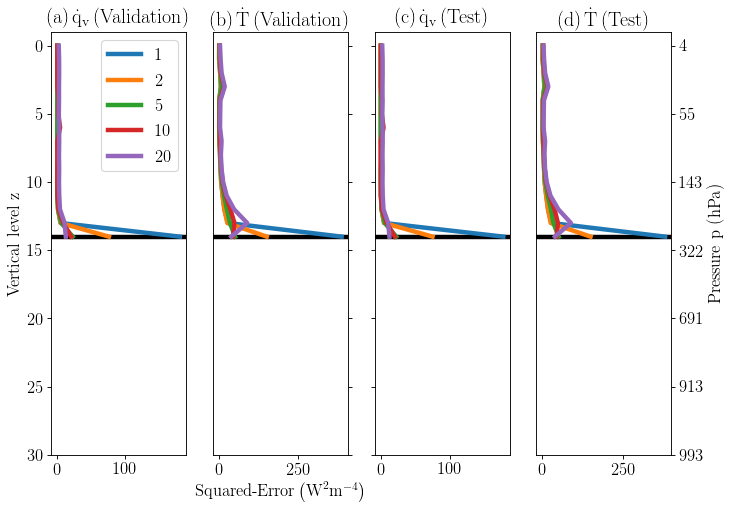

In [37]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):

        ax.plot(np.mean(S[datas]['SE'][multiplier][:,:15],axis=0),
                np.linspace(0,14,num=15),
                label=multiplier)
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):
        ax.plot(np.mean(S[datas]['SE'][multiplier][:,90:105],axis=0),
                np.linspace(0,14,num=15))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)

In [23]:
for j,datas in enumerate(DATASET):
    for im,multiplier in enumerate(mult_array):
        print(datas,multiplier,'MSE',np.mean(S[datas]['MSE'][multiplier]),
             'Constraints Penalty',np.mean(S[datas]['TRES'][multiplier]))

valid 1 MSE 157.56886 Constraints Penalty 7.8950213e-10
valid 2 MSE 158.60413 Constraints Penalty 8.162737e-10
valid 5 MSE 168.13551 Constraints Penalty 7.74125e-10
valid 10 MSE 185.50438 Constraints Penalty 6.989396e-10
valid 20 MSE 240.45724 Constraints Penalty 5.205835e-10
test 1 MSE 155.31773 Constraints Penalty 7.943441e-10
test 2 MSE 156.41902 Constraints Penalty 8.2314333e-10
test 5 MSE 165.89244 Constraints Penalty 7.793198e-10
test 10 MSE 182.82318 Constraints Penalty 7.072112e-10
test 20 MSE 237.21138 Constraints Penalty 5.26e-10


Save reduced data with mean and std of stats & res already calculated for less memory

In [29]:
S2 = S
for j,datas in enumerate(DATASET):
    for im,multiplier in enumerate(mult_array):
        S2[datas]['MSE'][multiplier] = (np.mean(S[datas]['MSE'][multiplier]),np.std(S[datas]['MSE'][multiplier]))
        S2[datas]['TRES'][multiplier] = (np.mean(S[datas]['TRES'][multiplier]),np.std(S[datas]['TRES'][multiplier]))

In [31]:
hf = open(pathPKL+'2020_03_09_weightedloss.pkl','wb')
pickle.dump(S2,hf)
hf.close()

## Non-linearly constrained network

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/041_ACnet_Non_Linear.ipynb]

In [46]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
NNarray = ['035_UCnet.hdf5','UCnetNL_10.hdf5','ACnetNL_10.hdf5',
          'UCnet_11.hdf5','UCnetNL_11.hdf5','ACnetNL_11.hdf5',
          'UCnet_12.hdf5','UCnetNL_12.hdf5','ACnetNL_12.hdf5']
NNname = ['$\mathrm{UCnet}$','$\mathrm{UCnet_{NL}}$','$\mathrm{ACnet_{NL}}$'] # TODO: Add UCnet_NL
col = ['k','r','b']
TITLE = [r'$\mathrm{\left(a\right)\dot\mathrm{RH}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\dot\mathrm{RH}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Test}\right)}$']
DATASET = ['valid','test']

In [47]:
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [48]:
S = {}

hf = open(pathPKL+'2020_03_04_validgen041.pkl','rb')
S['valid'] = pickle.load(hf)
hf.close()

hf = open(pathPKL+'2020_03_04_testgen041.pkl','rb')
S['test'] = pickle.load(hf)
hf.close()

FileNotFoundError: [Errno 2] No such file or directory: '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/2020_03_04_validgen041.pkl'

In [49]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        print('i=',i,'nn=',nn,'            ',end='\r')
        if i<3:
            ax.plot(np.mean(S[datas]['SE'][nn][:,:30],axis=0),
                np.linspace(0,29,num=30),
                label=NNname[i],color=col[i],linewidth=lw/2)
        else:
            ax.plot(np.mean(S[datas]['SE'][nn][:,:30],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2)
            
        
    if ifig==1: 
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        if i<3:
            ax.plot(np.mean(S[datas]['SE'][nn][:,90:120],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2,label=NNname[i])
        else:
            ax.plot(np.mean(S[datas]['SE'][nn][:,90:120],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2)
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
        plt.legend()
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig('Fig_prof_nl.pdf',format='pdf')

KeyError: 'valid'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa4439b1730> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)

kpathsea: Running mktexfmt latex.fmt
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt: kpsewhich -var-value=TEXMFROOT failed, aborting early.
BEGIN failed--compilation aborted at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)

kpathsea: Running mktexfmt latex.fmt
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt: kpsewhich -var-value=TEXMFROOT failed, aborting early.
BEGIN failed--compilation aborted at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




<Figure size 800x560 with 1 Axes>

In [72]:
for j,datas in enumerate(DATASET):
    for i,nn in enumerate(NNarray):
        print(datas,nn,'MSE',np.mean(S[datas]['MSE'][nn]),
             'Constraints Penalty',np.mean(S[datas]['TRES'][nn]))

valid 035_UCnet.hdf5 MSE 113.553785925987 Constraints Penalty 212366.71357283558
valid UCnetNL_10.hdf5 MSE 151.52250592805527 Constraints Penalty 3534.8022397378827
valid ACnetNL_10.hdf5 MSE 158.3656055163711 Constraints Penalty 0.0002111572260844254
test 035_UCnet.hdf5 MSE 113.71021776968766 Constraints Penalty 204024.85325491018
test UCnetNL_10.hdf5 MSE 151.2431999117424 Constraints Penalty 3492.563697030215
test ACnetNL_10.hdf5 MSE 157.3546145796691 Constraints Penalty 0.0002087446187475865


In [37]:
S2 = S
for j,datas in enumerate(DATASET):
    for i,nn in enumerate(NNarray):
        S2[datas]['MSE'][nn] = (np.mean(S[datas]['MSE'][nn]),np.std(S[datas]['MSE'][nn]))
        S2[datas]['TRES'][nn] = (np.mean(S[datas]['TRES'][nn]),np.std(S[datas]['TRES'][nn]))

In [38]:
hf = open(pathPKL+'2020_03_09_nl.pkl','wb')
pickle.dump(S2,hf)
hf.close()

# Tables

## Sensitivity to residual level

From reduced data

In [6]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [7]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEt = S['MSEt']
RESt = S['RESt']
lev = S['lev']

In [8]:
MSEt.keys()

dict_keys(['train', 'valid', 'test'])

In [9]:
MSEt['valid'].keys()

dict_keys(['Cm0_e0', 'Cm14_e14', 'Cm29_e29', 'Cm0_e29', 'Cm29_e0'])

In [10]:
TABLEname = 'Sens_reslev'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['train','valid','test']
DATANAM = ['Training','Validation','Test']
NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']
topline = "{\\small{}Dataset} & {\\small{}Metric} & $q_{0}T_{0}$ & $q_{14}T_{14}$ & $q_{29}T_{29}$ & $q_{0}T_{29}$ & $q_{29}T_{0}$\\tabularnewline\n"
caption = 'ACnets of varying residual levels for mass (m) and enthalpy (e) conservation, presented in Figure \\ref{Fig4} (Mean MSE/Penalty $\\pm $ Standard deviation)'

In [29]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(NNarray):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(NNarray):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Sens_reslev printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Sens_reslev.txt


## Comparison across Linear, UC/AC/LCnets

From NN reduced data calculated in 2.1.1

In [30]:
hf = open(pathPKL+'2020_03_06_comparison.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEt = S['MSEt']
RESt = S['RESt']

In [32]:
TABLEname = 'Comparison'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['train','valid','test']
DATANAM = ['Training','Validation','Test']
NNarray = ['MLRL0','JNNL','JNNL0.01','JNNC']
topline = "{\\small{}Validation} & {\\small{}Metric} & {\\small{}Linear} & $\\mathrm{UC_{net}}$ & $\\mathrm{LC_{net}\\left(\\alpha=0.01\\right)}$ & $\\mathrm{AC_{net}}$\\tabularnewline\n"
caption = 'NNs presented in Figure \\ref{Fig3}b (Mean MSE/Penalty $\\pm $ Standard deviation)'

In [33]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(NNarray):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(NNarray):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Comparison printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Comparison.txt


## Comparison across LCnets of different conservation weights

### Create reduced data from model

In [12]:
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [13]:
#config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
config_fn = '/export/home/tbeucler/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
#data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'
data_fn = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/8col009_01_test.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
DATASET = ['train','valid','test']

In [14]:
MSEv = {}
MSEt = {}
RESt = {}

for j,datas in enumerate(DATASET):
    print('datas=',datas)
    MSEv[datas] = {}
    MSEt[datas] = {}
    RESt[datas] = {}
    
    for alpha in alpha_array:
        print('alpha = ',str(alpha))
        NN = {}; md = {};

        # 1) Load model
        path = path_HDF5+'NNL'+str(alpha)+'.h5'
        NN = load_model(path,custom_objects=dict_lay)

        # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)

        # 3) Calculate statistics and save in pickle file
        path = path_HDF5+'NNL'+str(alpha)+'md_'+datas+'.pkl'
        md.stats = pickle.load(open(path,'rb'))
        MSEv[datas][alpha] = md.mse_W2m4().mean(axis=(0,1))
        MSEt[datas][alpha] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))

        # 4) Calculate budget residuals and save in pickle file
        path = path_HDF5+'NNL'+str(alpha)+'res_'+datas+'.pkl'
        md.res = pickle.load(open(path,'rb'))
        tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
        RESt[datas][alpha] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

datas= train
alpha =  0


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.01


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.25


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.5


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.75


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.99


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  1


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


datas= valid
alpha =  0


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.01


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.25


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.5


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.75


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.99


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  1


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


datas= test
alpha =  0


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.01


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.25


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.5


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.75


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.99


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  1


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [17]:
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2020_03_11_across_alpha.pkl','wb')
S = {"MSEv":MSEv,"MSEt":MSEt,"RESt":RESt,"lev":coor.lev}
pickle.dump(S,hf)
hf.close()

### Create table from reduced data

In [34]:
hf = open(pathPKL+'2020_03_11_across_alpha.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEt = S['MSEt']
RESt = S['RESt']
lev = S['lev']

In [35]:
TABLEname='Across_weights'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['train','valid','test']
DATANAM = ['Training','Validation','Test']
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
NN_array = [0,0.25,0.5,0.75,0.99] # Alpha values used for the table
topline = "{\\small{}Validation} & {\\small{}Metric} & $\\alpha=0$ & $\\alpha=0.25$ & $\\alpha=0.5$ & $\\alpha=0.75$ & $\\alpha=0.99$\\tabularnewline\n"
caption = 'LCnets of varying weight $\\alpha $, presented in Figure \\ref{Fig3}a (Mean MSE/Penalty $\\pm $ Standard deviation)'

In [36]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(NN_array):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(NN_array):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Across_weights printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Across_weights.txt


## Weighted loss to address residual bias

In [28]:
hf = open(pathPKL+'2020_03_09_weightedloss.pkl','rb')
S = pickle.load(hf)
hf.close()

DATASET = ['valid','test']
mult_array = np.array([1,2,5,10,20])

MSEt = {}
RESt = {}
for j,datas in enumerate(DATASET):
    MSEt[datas] = {}
    RESt[datas] = {}
    for im,multiplier in enumerate(mult_array):
        MSEt[datas][multiplier] = S[datas]['MSE'][multiplier]
        RESt[datas][multiplier] = S[datas]['TRES'][multiplier]

In [31]:
TABLEname='Targetted_loss'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['valid','test']
DATANAM = ['Validation','Test']
NNarray = mult_array
topline = "{\\small{}Validation} & {\\small{}Metric} & $\\beta=1$ & $\\beta=2$ & $\\beta=5$ & $\\beta=10$ & $\\beta=20$\\tabularnewline\n"
caption = 'ACnets with varying loss multiplier $\\beta $  given to the residual levels ($q_{14}T_{14}$) (Mean MSE/Penalty $\\pm $ Standard deviation)'

In [32]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(mult_array):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(mult_array):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Targetted_loss printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Targetted_loss.txt


## Non-linear UCnets and ACnets for RH

In [6]:
NNarray = ['035_UCnet.hdf5','UCnetNL_10.hdf5','ACnetNL_10.hdf5',
          'UCnet_11.hdf5','UCnetNL_11.hdf5','ACnetNL_11.hdf5',
          'UCnet_12.hdf5','UCnetNL_12.hdf5','ACnetNL_12.hdf5']
NNname = ['$\mathrm{UCnet}$','$\mathrm{UCnet_{NL}}$','$\mathrm{ACnet_{NL}}$'] # TODO: Add UCnet_NL

# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [7]:
hf = open(pathPKL+'2020_03_09_nl.pkl','rb')
S = pickle.load(hf)
hf.close()

DATASET = ['valid','test']
mult_array = np.array([1,2,5,10,20])

MSEt = {}
RESt = {}
for j,datas in enumerate(DATASET):
    print('j=',j,'datas=',datas)
    MSEt[datas] = {}
    RESt[datas] = {}
    for im,NNs in enumerate(NNarray):
        print('im=',im,'NNs=',NNs)
        MSEt[datas][NNs] = S[datas]['MSE'][NNs]
        RESt[datas][NNs] = S[datas]['TRES'][NNs]

j= 0 datas= valid
im= 0 NNs= 035_UCnet.hdf5
im= 1 NNs= UCnetNL_10.hdf5
im= 2 NNs= ACnetNL_10.hdf5
im= 3 NNs= UCnet_11.hdf5
im= 4 NNs= UCnetNL_11.hdf5
im= 5 NNs= ACnetNL_11.hdf5
im= 6 NNs= UCnet_12.hdf5
im= 7 NNs= UCnetNL_12.hdf5
im= 8 NNs= ACnetNL_12.hdf5
j= 1 datas= test
im= 0 NNs= 035_UCnet.hdf5
im= 1 NNs= UCnetNL_10.hdf5
im= 2 NNs= ACnetNL_10.hdf5
im= 3 NNs= UCnet_11.hdf5
im= 4 NNs= UCnetNL_11.hdf5
im= 5 NNs= ACnetNL_11.hdf5
im= 6 NNs= UCnet_12.hdf5
im= 7 NNs= UCnetNL_12.hdf5
im= 8 NNs= ACnetNL_12.hdf5


In [9]:
MSEt[datas][NNarray[im]]

(113.553785925987, 508.73208296636716)

In [11]:
NNmean = ['UC','UCnl','ACnl']
MSEtm = {}
REStm = {}
for j,datas in enumerate(DATASET):
    print('j=',j,'datas=',datas)
    MSEtm[datas] = {}
    REStm[datas] = {}
    for im,NNs in enumerate(NNmean):
        print('im=',im,'NNs=',NNs)
        MSEtm[datas][NNs] = ((MSEt[datas][NNarray[im]][0]+MSEt[datas][NNarray[3+im]][0]+MSEt[datas][NNarray[6+im]][0])/3,
                            (MSEt[datas][NNarray[im]][1]+MSEt[datas][NNarray[3+im]][1]+MSEt[datas][NNarray[6+im]][1])/3)
        REStm[datas][NNs] = ((RESt[datas][NNarray[im]][0]+RESt[datas][NNarray[3+im]][0]+RESt[datas][NNarray[6+im]][0])/3,
                            (RESt[datas][NNarray[im]][1]+RESt[datas][NNarray[3+im]][1]+RESt[datas][NNarray[6+im]][1])/3)

j= 0 datas= valid
im= 0 NNs= UC
im= 1 NNs= UCnl
im= 2 NNs= ACnl
j= 1 datas= test
im= 0 NNs= UC
im= 1 NNs= UCnl
im= 2 NNs= ACnl


In [23]:
TABLEname='ACnet_NL'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['valid','test']
DATANAM = ['Validation','Test']
NNarray = mult_array
topline = "{\\small{}Validation} & {\\small{}Metric} & $\\mathrm{UCnet}$ & $\\mathrm{UCnet_{NL}}$ & $\\mathrm{ACnet_{NL}}$\\tabularnewline\n"
caption = 'NNs presented in Figure \\ref{fig:D_schematic} (Ensemble mean of Mean MSE/Penalty $\\pm $ Standard deviation). MSE is calculated using relative humidity tendencies, explaining its smaller values.'

In [24]:
path

'/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/ACnet_NL.txt'

In [25]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(NNmean):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEtm[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEtm[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEtm[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEtm[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNmean)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(NNmean):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(REStm[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(REStm[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(REStm[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(REStm[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNmean)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\label{tab:D_results}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table ACnet_NL printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/ACnet_NL.txt
